In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

## Loading and visualizing data

In [2]:
df_in = pd.read_csv('input_v.csv', header = None)
df_out = pd.read_csv('output_v.csv', header = None)
display(df_in.head())
display(df_out.head())

,0,1,2
0,0.6,0.6,0.40
1,0.6,0.6,0.55
2,0.6,0.6,0.70
3,0.6,0.7,0.40
4,0.6,0.7,0.55


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,2.0,2.0,2.0,2.0,2.0,2.0,2.134859,2.867460,3.964918,5.675808,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.144754,2.868371,4.001123,5.709306,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.105326,2.834866,3.934640,5.526055,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.337638,3.424727,5.262582,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.337111,3.444411,5.327305,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [3]:
df_in.shape, df_out.shape

((82, 3), (82, 50))

There are 82 records in the data set. The size of the input space is 3 and the size of the output space is 50.

For the rank, it may refer to two meanings:
- in linear algebra, it's the maximum number of linearly independent variables. In this case, we will see that later.
- In a tensor (multi-dimensional arrays) point of view, the rank is the number of dimension of a tensor. In this case, the input and the output are both of rank 2.

##### Train/test split

In [10]:
X, Y = df_in.values, df_out.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((65, 3), (65, 50), (17, 3), (17, 50))

## Machine Learning

In [11]:
# check that the rank of output matrix is 37 

np.linalg.matrix_rank(Y)

37

In [12]:
# drop columns with constant values and check that the outcome has about 37 columns once constant columns removed.

fs = VarianceThreshold(threshold = 0)
fs.fit(Y_train)
Y_train = fs.transform(Y_train)
Y_test = fs.transform(Y_test)
Y_train.shape, Y_test.shape

((65, 36), (17, 36))

We removed all columns having null variance. The output space is now of size around 37 (35, 36 or 37), depending on the performed shuffle in the train/test split.

In [13]:
estimators_params = {
    Lasso(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    Ridge(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    ElasticNet(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [i / 10. for i in range(1, 10)]
    }
}

for estimator, param_grid in estimators_params.items():
    gscv = GridSearchCV(estimator, param_grid, scoring = 'r2', cv = 10, n_jobs = -1)
    gscv.fit(X_train, Y_train)
    # using the best estimator (with the best params) found by the grid-search cross-valiadation
    # to compute the R2 and the MAE on the testing set
    Y_pred = gscv.best_estimator_.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    print(gscv.best_estimator_)
    print(f'R^2: {r2}')
    print(f'MAE: {mae}')

Lasso(alpha=0.01, max_iter=150, tol=0.001)
R^2: 0.6168671983487224
MAE: 0.8827832924093585
Ridge(alpha=0.1, max_iter=150)
R^2: 0.622613723192163
MAE: 0.9669555184562378
ElasticNet(alpha=0.001, l1_ratio=0.1)
R^2: 0.6446259724195288
MAE: 0.9107349501081848


The lasso with the hyperparameters above performs the best. However, 0.59 is not a satisfying score. 

A better way of abording this problem using linear models would be to train a separate model for each output variable (Y_i). This will fix the parameter-sharing issue. Also, the objective function (here the MSE) will be defined for each output variable which means that the model will optimize seperate MSEs rather than an average of MSEs... Let's do it as a bonus!

In [14]:
estimators_params = {
    Lasso(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    Ridge(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    ElasticNet(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [i / 10. for i in range(1, 10)]
    }
}

best_estimators = dict()
for j in tqdm(range(Y_train.shape[1])):
    # extract y_j
    y_train = Y_train[:, j]
    y_test = Y_test[:, j]
    # GSCV
    r2_max = -np.inf
    for estimator, param_grid in estimators_params.items():
        gscv = GridSearchCV(estimator, param_grid, scoring = 'r2', cv = 10, n_jobs = -1)
        gscv.fit(X_train, y_train)
        # evaluate
        y_pred = gscv.best_estimator_.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        if r2_max < r2:
            r2_max = r2
            best_estimators[j] = gscv.best_estimator_

In [15]:
Y_pred = np.empty_like(Y_test)

for j, best_estimator in best_estimators.items():
    y_test = Y_test[:, j]
    y_pred = best_estimator.predict(X_test)
    Y_pred[:, j] = y_pred
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Variable {j}:')
    print(f'  Best estimator: {best_estimator}')
    print(f'  R^2: {r2}')
    print(f'  MAE: {mae}')

r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(f'Combined R^2: {r2}')
print(f'Combined MAE: {mae}')

Variable 0:
  Best estimator: Lasso(alpha=0.001, max_iter=150, tol=1e-07)
  R^2: 0.5010171315555518
  MAE: 0.06694185297079351
Variable 1:
  Best estimator: Lasso(alpha=0.001, max_iter=150, tol=1e-07)
  R^2: 0.3910087276381943
  MAE: 0.2077085082677368
Variable 2:
  Best estimator: Ridge(max_iter=150)
  R^2: 0.0915759847918205
  MAE: 0.40877372085557184
Variable 3:
  Best estimator: Ridge(alpha=0.1, max_iter=150)
  R^2: -0.02470624504642549
  MAE: 0.6706359573857675
Variable 4:
  Best estimator: ElasticNet(alpha=0.001, l1_ratio=0.3)
  R^2: 0.22308782755363743
  MAE: 0.7439887193877907
Variable 5:
  Best estimator: ElasticNet(alpha=0.001)
  R^2: 0.826444477578151
  MAE: 0.5396791987948387
Variable 6:
  Best estimator: Lasso(alpha=0.001, max_iter=150, tol=1e-07)
  R^2: 0.9529091558438862
  MAE: 0.35843813733183866
Variable 7:
  Best estimator: Ridge(alpha=0.0001, max_iter=150)
  R^2: 0.9723033147182506
  MAE: 0.2575285734095214
Variable 8:
  Best estimator: Ridge(alpha=0.0001, max_iter=1

We have a slight improvement of the $R^2$. 
However, we now know which variables are causing the linear model to fail (the ones with a low $R^2$).

plot y_pred vs. y_test

Since we are in a multi-dimensional space, how can we plot in a graph y_pred vs y_test?

Two options:

- make a plot for each Y_test variable (you can put it on a grid)
- flatten your data

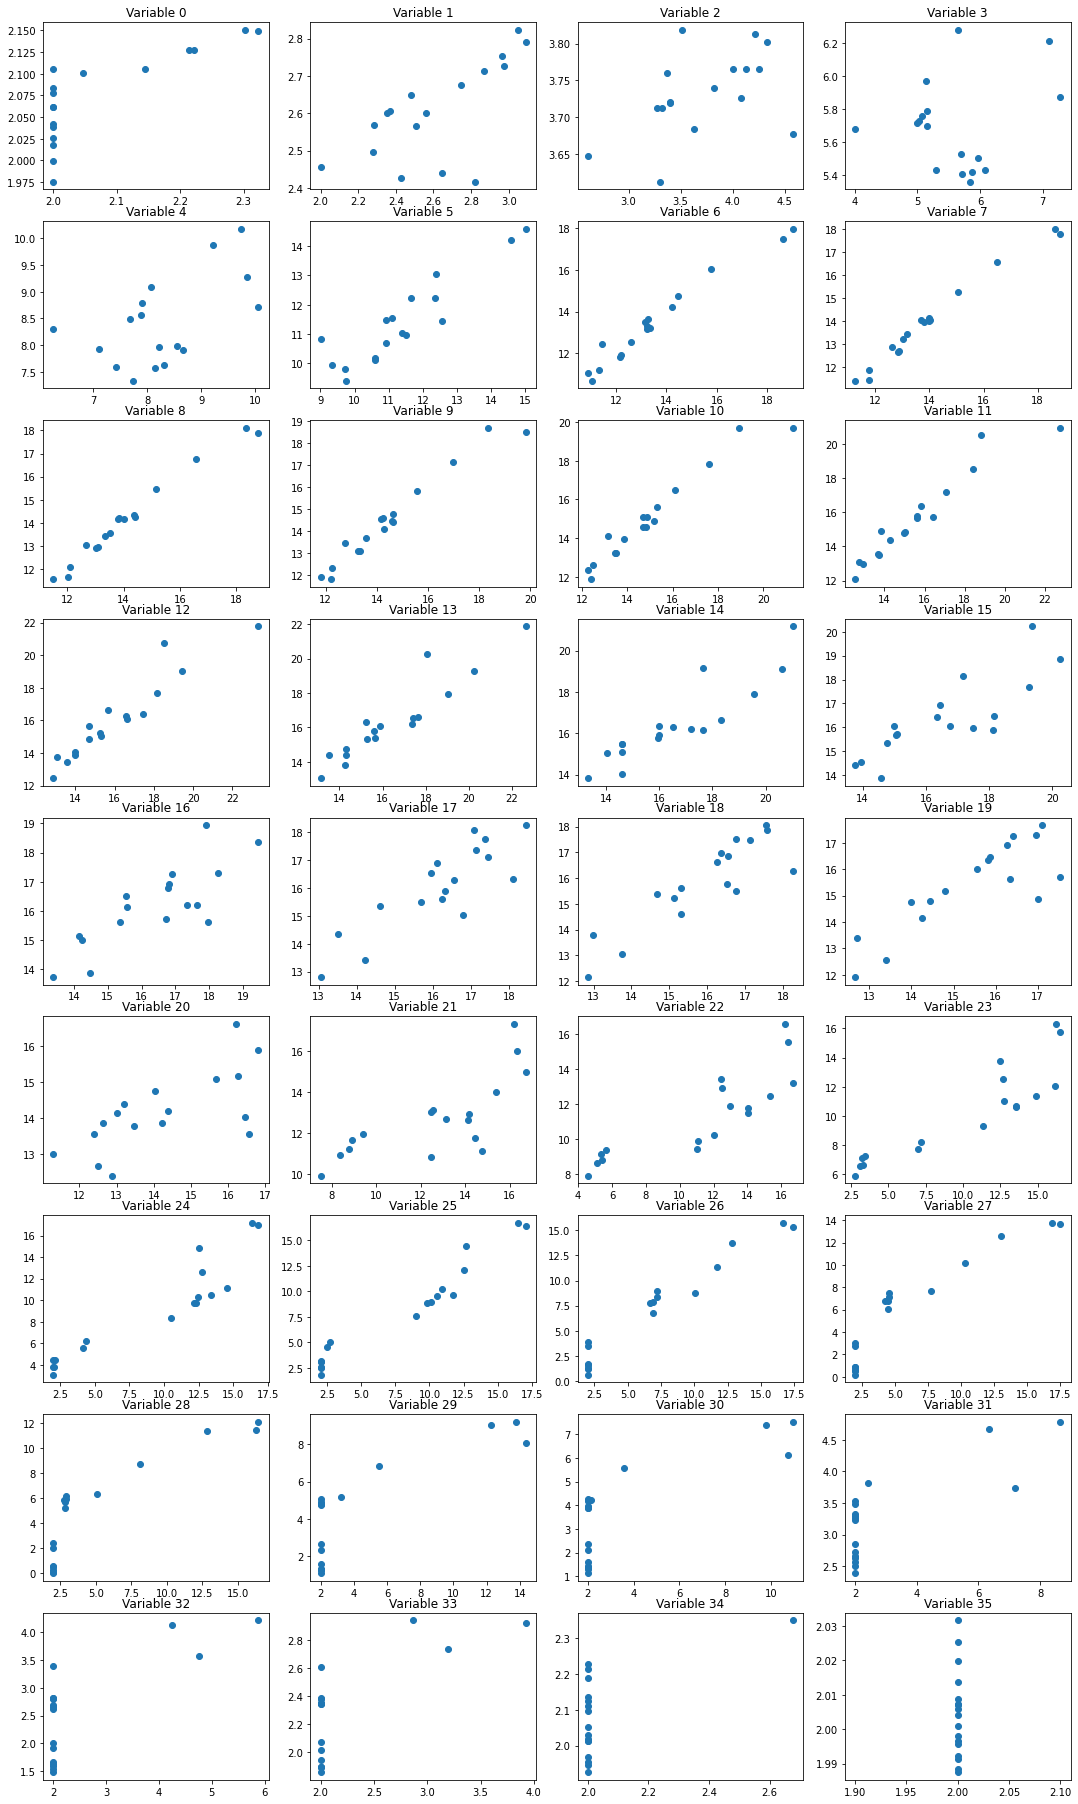

In [39]:
fig, axs = plt.subplots(9, 4, figsize=(15, 25))
fig.tight_layout()

for j, ax in enumerate(axs.flatten()):
    if j >= Y_test.shape[1]:
        break
    ax.scatter(x=Y_test[:, j], y=Y_pred[:, j])
    ax.set_title(f"Variable {j}")

<AxesSubplot:xlabel='actual', ylabel='predicted'>

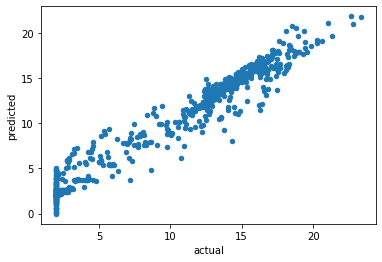

In [28]:
pd.DataFrame({
    "predicted": Y_pred.flatten(),
    "actual": Y_test.flatten()
}).plot.scatter(y="predicted", x="actual")

## Reversing the problem

In [40]:
# Reversing things
df_in_rev, df_out_rev = df_out, df_in
print(df_in_rev.shape, df_out_rev.shape)

# train/test split
X, Y = df_in_rev.values, df_out_rev.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(82, 50) (82, 3)


((65, 50), (65, 3), (17, 50), (17, 3))

In [41]:
# Use truncatedSVD to see if one can reduce the size of the problem.

tsvd = TruncatedSVD(n_components = 49, n_iter = 7)
tsvd.fit(X_train)
sv = tsvd.singular_values_
ev = tsvd.explained_variance_.tolist()
evr = tsvd.explained_variance_ratio_.tolist()
df_svd = pd.DataFrame(data = {
    'singular_value': sv,
    'explained_variance': ev,
    'explained_variance_ratio': evr
})
df_svd.round(2)

,singular_value,explained_variance,explained_variance_ratio
0,562.99,93.54,0.34
1,90.41,124.66,0.45
2,48.70,36.45,0.13
3,23.96,8.83,0.03
4,16.46,4.17,0.02
5,12.74,2.49,0.01
6,11.56,2.05,0.01
7,7.95,0.97,0.00
8,4.47,0.31,0.00
9,3.75,0.22,0.00


In [42]:
# let's fix a threshold of 1% on the percentage of variance explained by each of the selected components (explained variance ratio).
# this means that we need only 6 components.

tsvd = TruncatedSVD(n_components = 6, n_iter = 7)
tsvd.fit(X_train)
X_train = tsvd.transform(X_train)
X_test = tsvd.transform(X_test)
X_train.shape, X_test.shape

((65, 6), (17, 6))

In [43]:
# Use KNN regression and compare with LM

estimators_params = {
    Lasso(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    Ridge(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'max_iter': [150, 300, 500, 700, 1000, 1300],
        'tol': [1e-3, 1e-5, 1e-7],
    },
    ElasticNet(): {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [i / 10. for i in range(1, 10)]
    },
    KNeighborsRegressor(): {
        'n_neighbors': [1, 3, 5, 7, 10],
        'weights': ['uniform', 'distance'],    
        'leaf_size': [30, 50, 70, 100],
    }
}

for estimator, param_grid in estimators_params.items():
    gscv = GridSearchCV(estimator, param_grid, scoring = 'r2', cv = 10, n_jobs = -1)
    gscv.fit(X_train, Y_train)
    # using the best estimator (with the best params) found by the grid-search cross-valiadation
    # to compute the R2 and the MAE on the testing set
    Y_pred = gscv.best_estimator_.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    print(gscv.best_estimator_)
    print(f'R^2: {r2}')
    print(f'MAE: {mae}')

Lasso(alpha=0.01, max_iter=150, tol=0.001)
R^2: 0.6172318838725243
MAE: 0.06702372408512515
Ridge(max_iter=150)
R^2: 0.6165859248593152
MAE: 0.0651138325035258
ElasticNet(alpha=0.1, l1_ratio=0.2)
R^2: 0.6044178885384596
MAE: 0.06857077203144886
KNeighborsRegressor(weights='distance')
R^2: 0.6339915088981167
MAE: 0.05977618777759163


KNN regressor completely fails. The best linear model score is 0.61, so there is still room to make improvement.

In [44]:
# same with SVM. How to handle multiple outputs ?
# we can handle multiple outputs by using multiple SVRs

param_grid = [
    {
        'estimator__kernel': ['linear'],
        'estimator__C': [0.01, 0.1, 1, 10],
    },
    {
        'estimator__kernel': ['rbf'],
        'estimator__C': [0.01, 0.1, 1, 10],
        'estimator__gamma': ['scale', 'auto'],
    },
    {
        'estimator__kernel': ['poly'],
        'estimator__C': [0.01, 0.1, 1, 10],
        'estimator__degree': [2, 3],
        'estimator__gamma': ['scale', 'auto'],
    },
    {
        'estimator__kernel': ['sigmoid'],
        'estimator__C': [0.01, 0.1, 1, 10],
        'estimator__gamma': ['scale', 'auto'],
    }
]

svr = SVR()
wrapper = MultiOutputRegressor(svr)

gscv = GridSearchCV(wrapper, param_grid, scoring = 'r2', cv = 10, n_jobs = -1)
gscv.fit(X_train, Y_train)
Y_pred = gscv.best_estimator_.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(gscv.best_estimator_)
print(f'R^2: {r2}')
print(f'MAE: {mae}')

MultiOutputRegressor(estimator=SVR(C=0.01, degree=2, gamma='auto',
                                   kernel='poly'))
R^2: 0.10405542590132484
MAE: 0.07537286918229325


Same, support vector machines fail, and it's computationally expensive to perform a grid search CV.

In [48]:
# Random forest

param_grid = [
    {
        'estimator__bootstrap': [True],
        'estimator__oob_score': [True, False],
        'estimator__n_estimators': [10, 30, 70, 100, 170, 230],
        'estimator__criterion': ['mse', 'mae'],
        'estimator__max_features': ['sqrt', 'log2', None],
    }, 
    {
        'estimator__bootstrap': [False],
        'estimator__oob_score': [False],
        'estimator__n_estimators': [10, 30, 70, 100, 170, 230],
        'estimator__criterion': ['mse', 'mae'],
        'estimator__max_features': ['sqrt', 'log2', None],
    }
]


rf = RandomForestRegressor()
wrapper = MultiOutputRegressor(rf)

gscv = GridSearchCV(wrapper, param_grid, scoring = 'r2', cv = 10, n_jobs = -1, verbose=2)
gscv.fit(X_train, Y_train)
Y_pred = gscv.best_estimator_.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(gscv.best_estimator_)
print(f'R^2: {r2}')
print(f'MAE: {mae}')

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


MultiOutputRegressor(estimator=RandomForestRegressor(max_features=None,
                                                     n_estimators=70,
                                                     oob_score=True))
R^2: 0.7552164170845511
MAE: 0.043326330532213124


Nice, 0.7 is a better score.